# Experimento 14

Se incluye una regresion lineal al final, se utiliza el modelo del experimento 13

In [128]:
import os
import numpy as np
import imageio
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
print("GPU detectada:", tf.test.gpu_device_name())

GPU detectada: /device:GPU:0


In [131]:
# Rutas de los conjuntos de entrenamiento y validación
train_path = '/content/drive/MyDrive/NCZ/10 Projects/MAA-Cone-Density-Estimation/data/machine1_5/Training+Density/'
val_path   = '/content/drive/MyDrive/NCZ/10 Projects/MAA-Cone-Density-Estimation/data/machine1_5/Validation+Density/'

In [132]:
# Función para leer y preprocesar datos
def read_data(base_path, density_threshold=400):
    data = []
    anno = []
    file_list = os.listdir(base_path)
    for filename in file_list:
        if 'Density' in filename:
            base_filename = filename[:-11] + '.tif'
            img_path = os.path.join(base_path, base_filename)
            dens_path = os.path.join(base_path, filename)
            if os.path.exists(img_path) and os.path.exists(dens_path):
                # Cargar imagen y normalizar a [0,1]
                img = np.asarray(Image.open(img_path).convert("RGB")).astype(np.float32) / 255.0
                # Cargar mapa de densidad
                density = imageio.imread(dens_path).astype(np.float32)
                # Filtrado basado en la suma (ajustar el umbral)
                if np.sum(density) / 100 < density_threshold:
                    data.append(img)
                    # Expandir la dimensión para que tenga forma (H, W, 1)
                    density = np.expand_dims(density, axis=-1)
                    anno.append(density)
    return np.array(data), np.array(anno)

In [101]:
# Cargar conjuntos de entrenamiento y validación
train_images, train_density_maps = read_data(train_path, density_threshold=400)
val_images, val_density_maps = read_data(val_path, density_threshold=400)

print("Train images shape:", train_images.shape)
print("Train density maps shape:", train_density_maps.shape)
print("Validation images shape:", val_images.shape)
print("Validation density maps shape:", val_density_maps.shape)

<ipython-input-100-334694396>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  density = imageio.imread(dens_path).astype(np.float32)


Train images shape: (184, 256, 256, 3)
Train density maps shape: (184, 256, 256, 1)
Validation images shape: (80, 256, 256, 3)
Validation density maps shape: (80, 256, 256, 1)


In [102]:
# Función de data augmentation (flip y rotaciones)
def augment(image, density):
    # Flip horizontal aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        density = tf.image.flip_left_right(density)
    # Flip vertical aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        density = tf.image.flip_up_down(density)
    # Rotación aleatoria múltiplo de 90 grados
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    density = tf.image.rot90(density, k)
    return image, density

# Crear datasets tf.data para entrenamiento y validación
batch_size = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_density_maps))
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, (256,256)), tf.image.resize(y, (256,256))))
train_dataset = train_dataset.map(augment)
train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_density_maps))
val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, (256,256)), tf.image.resize(y, (256,256))))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [103]:
print("Número de batches en entrenamiento:", len(list(train_dataset)))

Número de batches en entrenamiento: 23


In [104]:
#Construcción del modelo U-Net mejorado
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

# Entrada del modelo
inputs = layers.Input(shape=(256,256,3))

# Encoder
c1, p1 = encoder_block(inputs, 16)
c2, p2 = encoder_block(p1, 32)
c3, p3 = encoder_block(p2, 64)

# Cuello de botella con Dropout para regularización
b = conv_block(p3, 128)
b = layers.Dropout(0.5)(b)

# Decoder
def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(x)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters)
    return x

d1 = decoder_block(b, c3, 64)
d2 = decoder_block(d1, c2, 32)
d3 = decoder_block(d2, c1, 16)

# Salida: Mapa de densidad con activación ReLU para evitar valores negativos
outputs = layers.Conv2D(1, (1,1), activation='relu')(d3)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_75[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_70       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 256, 256,  │      2,320 │ activation_70[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_71       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 128, 128,  │          0 │ activation_71[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_15… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_72       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_72[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_73       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 64, 64,    │          0 │ activation_73[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_79[0][0] 

 Total params: 538,609 (2.05 MB)

 Trainable params: 537,201 (2.05 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [105]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='mse',
              metrics=['mae'])

In [106]:
# Evaluación del modelo
model.load_weights('Model_A.h5')
val_loss, val_mae = model.evaluate(val_dataset)
print(f"Validación - MSE: {val_loss:.3f}, MAE: {val_mae:.3f}")

# Predicción y visualización en una imagen de val
for test_img, true_density in val_dataset.take(1):
    test_img_sample = test_img[1]
    true_density_sample = true_density[1]

predicted_map = model.predict(tf.expand_dims(test_img_sample, axis=0)).squeeze()


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.0935 - mae: 0.2495
Validación - MSE: 1.210, MAE: 0.274
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step


`tf.expand_dims(test_img_sample, axis=0)` agrega una dimensión al tensor para que pase de `(256, 256, 3)` a `(1, 256, 256, 3)`. El "1" indica el tamaño del batch. Esto es porque el modelo espera un input en lote.

`squeeze` elimina la dimensión de tamaño 1. Esto para eliminar lo adicionado anteriormente.

Conteo real: 5400.00 | Conteo predicho: 6354.29


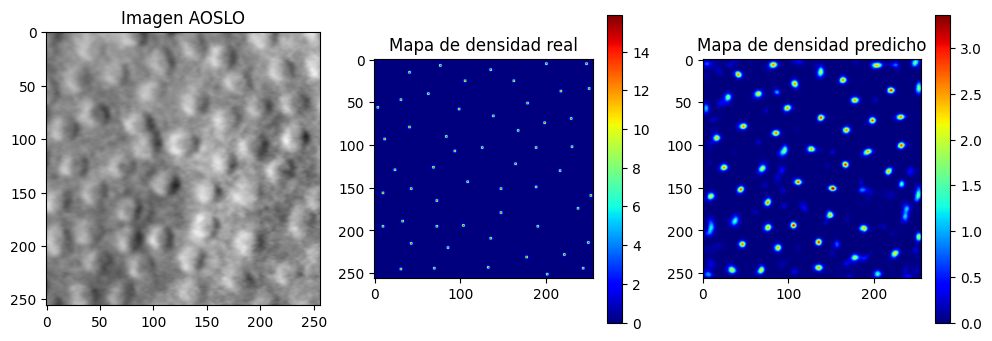

In [107]:
# Cálculo del conteo (suma del mapa)
true_count = np.sum(true_density_sample)
pred_count = np.sum(predicted_map)
print(f"Conteo real: {true_count:.2f} | Conteo predicho: {pred_count:.2f}")

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(test_img_sample)
plt.title("Imagen AOSLO")

plt.subplot(1,3,2)
plt.imshow(true_density_sample[:,:,0], cmap='jet')
plt.title("Mapa de densidad real")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(predicted_map, cmap='jet')
plt.title("Mapa de densidad predicho")
plt.colorbar()

plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step


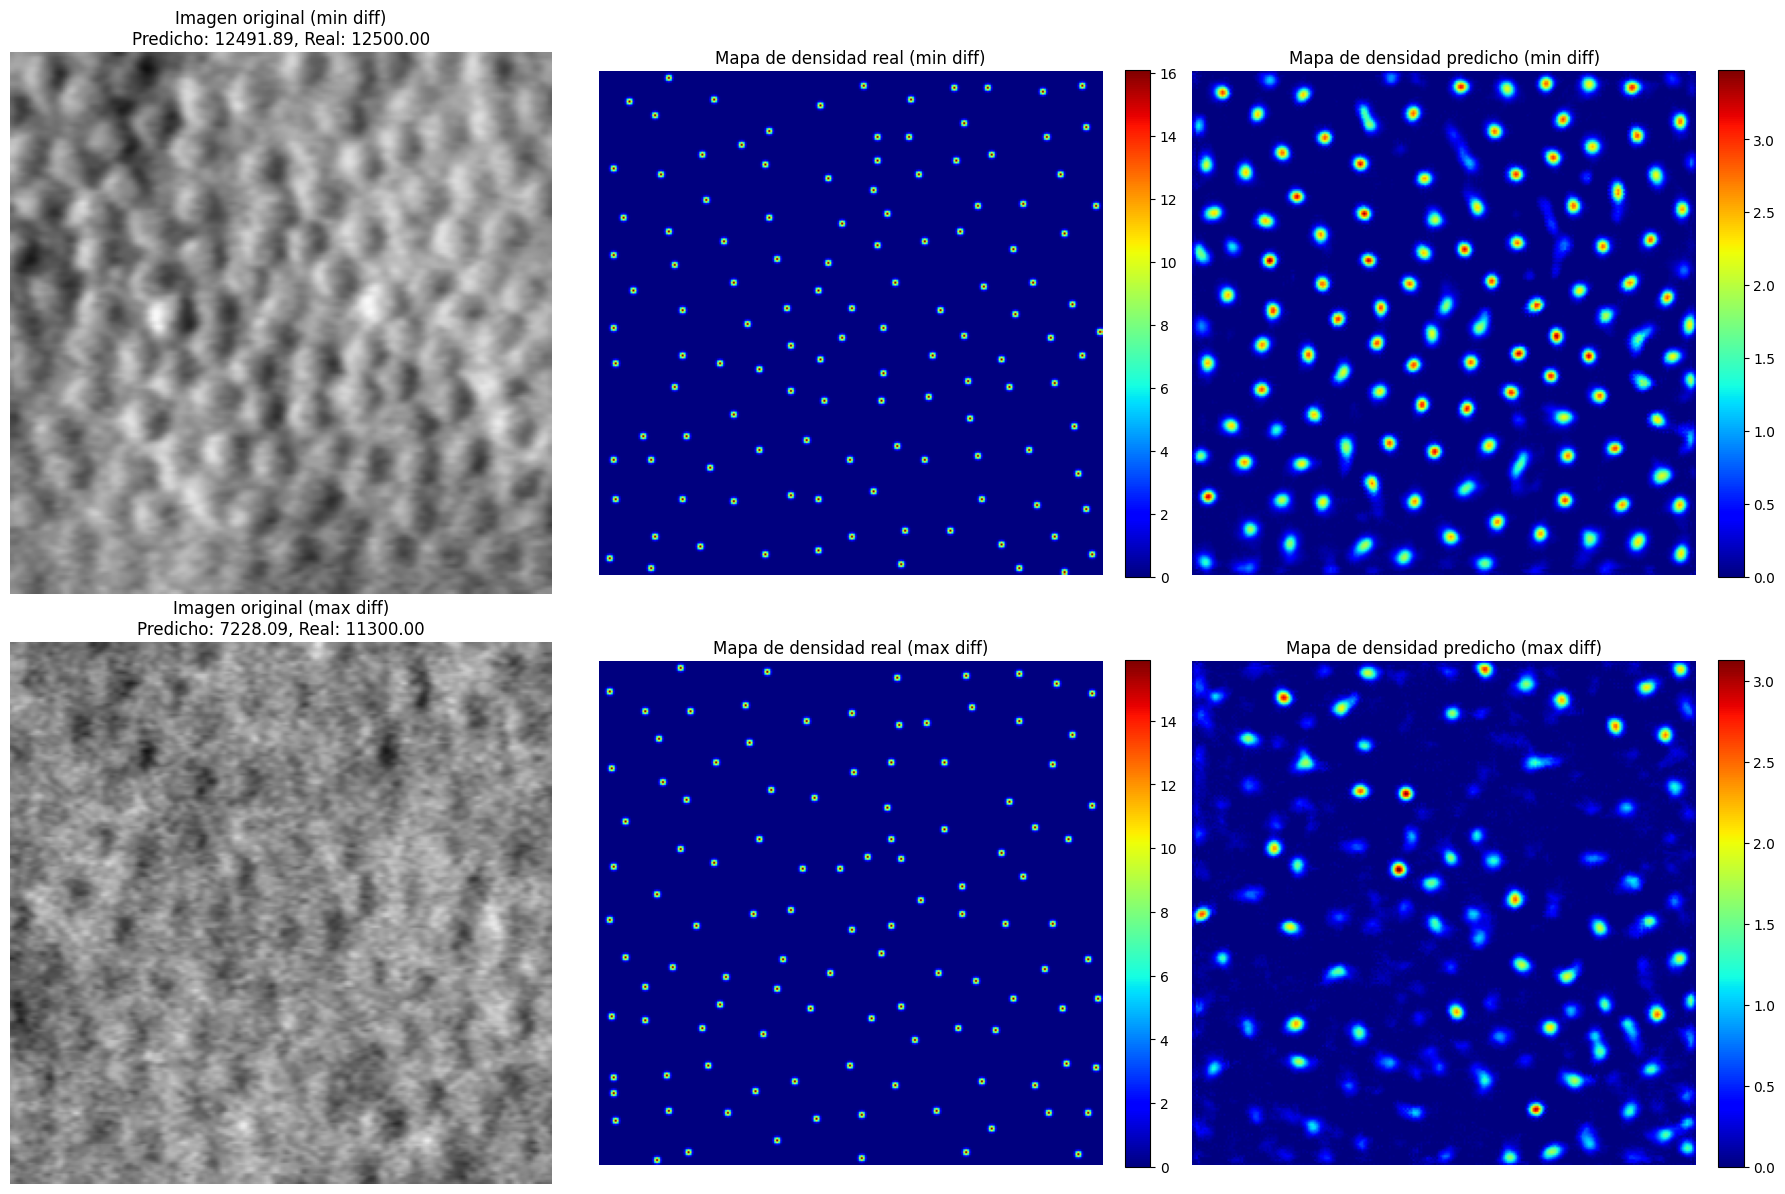

In [108]:

# Acumular todas las imágenes y mapas de densidad del conjunto de validación
val_images_all = []
val_density_all = []

for test_img, true_density in val_dataset:
    # Convertimos cada batch a numpy y lo acumulamos
    val_images_all.append(test_img.numpy())
    val_density_all.append(true_density.numpy())

# Concatenar todos los batches en un solo array
val_images_all = np.concatenate(val_images_all, axis=0)
val_density_all = np.concatenate(val_density_all, axis=0)

# Realizar predicciones en todas las imágenes de validación
val_predictions = model.predict(val_images_all)

# Calcular el conteo total (suma del mapa) para cada imagen
pred_counts = np.sum(val_predictions, axis=(1,2,3))
true_counts = np.sum(val_density_all, axis=(1,2,3))

# Calcular la diferencia absoluta entre el conteo real y el predicho
diff = np.abs(true_counts - pred_counts)

# Obtener los índices de la imagen con menor y mayor diferencia
min_idx = np.argmin(diff)
max_idx = np.argmax(diff)

# Preparar la gráfica para las imágenes con menor y mayor diferencia
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Caso de menor diferencia
min_pred_count = pred_counts[min_idx]
min_true_count = true_counts[min_idx]

# Imagen original con anotación en el título
axes[0, 0].imshow(val_images_all[min_idx])
axes[0, 0].set_title(f'Imagen original (min diff)\nPredicho: {min_pred_count:.2f}, Real: {min_true_count:.2f}')
axes[0, 0].axis('off')

# Mapa de densidad real con escala de colores
im_real_min = axes[0, 1].imshow(val_density_all[min_idx].squeeze(), cmap='jet')
axes[0, 1].set_title('Mapa de densidad real (min diff)')
axes[0, 1].axis('off')
plt.colorbar(im_real_min, ax=axes[0, 1], fraction=0.046, pad=0.04)

# Mapa de densidad predicho con escala de colores
im_pred_min = axes[0, 2].imshow(val_predictions[min_idx].squeeze(), cmap='jet')
axes[0, 2].set_title('Mapa de densidad predicho (min diff)')
axes[0, 2].axis('off')
plt.colorbar(im_pred_min, ax=axes[0, 2], fraction=0.046, pad=0.04)

# Caso de mayor diferencia
max_pred_count = pred_counts[max_idx]
max_true_count = true_counts[max_idx]

# Imagen original con anotación en el título
axes[1, 0].imshow(val_images_all[max_idx])
axes[1, 0].set_title(f'Imagen original (max diff)\nPredicho: {max_pred_count:.2f}, Real: {max_true_count:.2f}')
axes[1, 0].axis('off')

# Mapa de densidad real con escala de colores
im_real_max = axes[1, 1].imshow(val_density_all[max_idx].squeeze(), cmap='jet')
axes[1, 1].set_title('Mapa de densidad real (max diff)')
axes[1, 1].axis('off')
plt.colorbar(im_real_max, ax=axes[1, 1], fraction=0.046, pad=0.04)

# Mapa de densidad predicho con escala de colores
im_pred_max = axes[1, 2].imshow(val_predictions[max_idx].squeeze(), cmap='jet')
axes[1, 2].set_title('Mapa de densidad predicho (max diff)')
axes[1, 2].axis('off')
plt.colorbar(im_pred_max, ax=axes[1, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

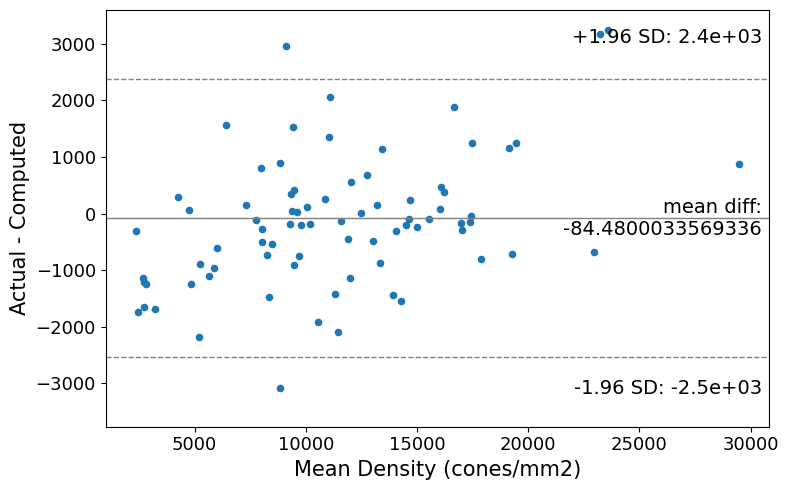

In [109]:
# Gráfico de mean-diff (Bland–Altman)
f, ax = plt.subplots(1, figsize=(8, 5))
sm.graphics.mean_diff_plot(true_counts, pred_counts, ax=ax)

plt.ylabel('Actual - Computed')
plt.xlabel('Mean Density (cones/mm2)')
plt.show()

# Regresión Lineal

In [110]:
def predict_counts(dataset, model):
    preds, true_maps = [], []
    for imgs, dens in dataset:
        preds.append(model.predict(imgs))
        true_maps.append(dens.numpy())
    preds = np.concatenate(preds, axis=0)
    true_maps = np.concatenate(true_maps, axis=0)
    counts_pred = np.sum(preds, axis=(1, 2, 3))
    counts_true = np.sum(true_maps, axis=(1, 2, 3))
    return counts_pred, counts_true

## Train

In [111]:
train_pred_counts, train_true_counts = predict_counts(train_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


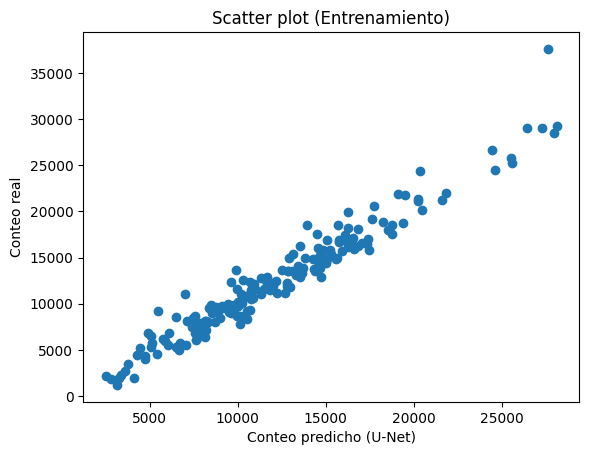

In [112]:
X_train = train_pred_counts.reshape(-1, 1) #Es necesario hacer reshape para que pase de (184,) a (184,1)
y_train = train_true_counts

plt.figure()
plt.scatter(X_train, y_train)
plt.xlabel("Conteo predicho (U-Net)")
plt.ylabel("Conteo real")
plt.title("Scatter plot (Entrenamiento)")
plt.show()

## Val

In [113]:
# Obtener predicciones para el conjunto de validación
val_pred_counts, val_true_counts = predict_counts(val_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


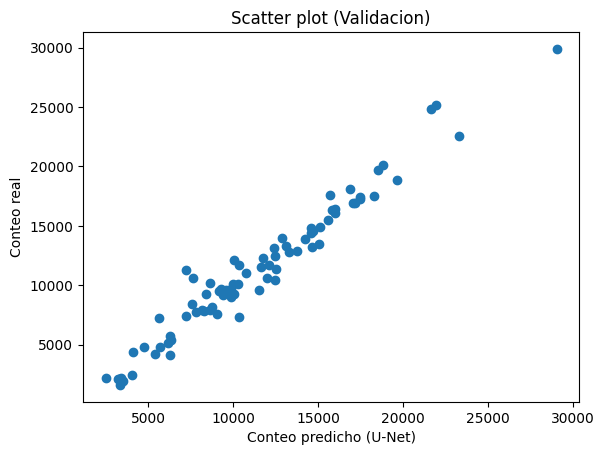

In [114]:
X_val = val_pred_counts.reshape(-1, 1)
y_val = val_true_counts

plt.figure()
plt.scatter(X_val, y_val)
plt.xlabel("Conteo predicho (U-Net)")
plt.ylabel("Conteo real")
plt.title("Scatter plot (Validacion)")
plt.show()

## Regresión lineal

In [115]:
# Ajustar reg lineal
reg = LinearRegression().fit(X_train, y_train)

In [116]:
# parámetros del modelo
slope = reg.coef_[0]
intercept = reg.intercept_
print(f"Regresión lineal ajustada: y = {slope:.4f} * x + {intercept:.4f}")
print(f'Score en entrenamiento: {reg.score(X_train, y_train):.4f}')

Regresión lineal ajustada: y = 1.0816 * x + -671.1797
Score en entrenamiento: 0.9448


In [117]:
# Evaluacion de la regresion sobre validacion
# Predecir conteos corregidos para el conjunto de validación
corrected_val_counts = reg.predict(X_val)

# Calcular el error absoluto medio (MAE) antes y después de la corrección
mae_before = mean_absolute_error(val_true_counts, val_pred_counts)
mae_after = mean_absolute_error(val_true_counts, corrected_val_counts)

# Calcular el error cuadrático medio (MSE) antes y después de la corrección
mse_before = mean_squared_error(val_true_counts, val_pred_counts)
mse_after = mean_squared_error(val_true_counts, corrected_val_counts)

# Imprimir resultados
print(f"MAE antes: {mae_before:.4f} | MAE después: {mae_after:.4f}")
print(f"MSE antes: {mse_before:.4f} | MSE después: {mse_after:.4f}")

MAE antes: 921.6240 | MAE después: 977.0461
MSE antes: 1575495.3750 | MSE después: 1571433.6250


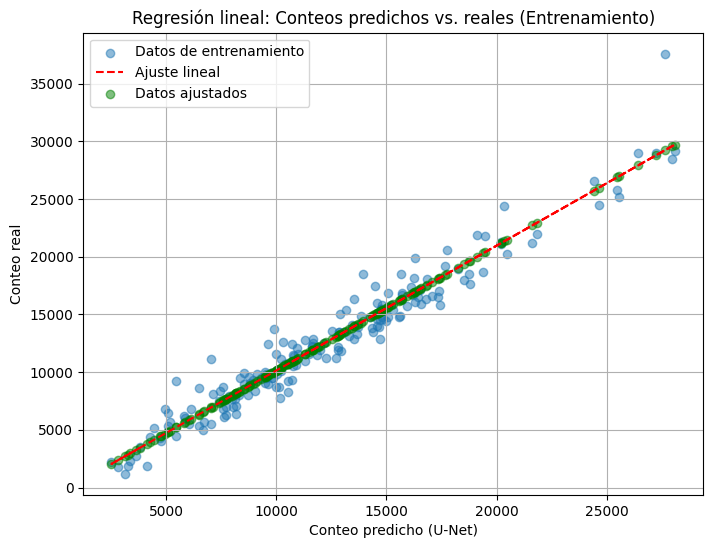

In [119]:
# Gráfico para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
plt.scatter(train_pred_counts, train_true_counts, label="Datos de entrenamiento", alpha=0.5)
plt.plot(train_pred_counts, reg.predict(X_train), color="red", linestyle='--', label="Ajuste lineal")
plt.scatter(X_train, reg.predict(X_train), color='green', label="Datos ajustados",alpha=0.5)
plt.xlabel("Conteo predicho (U-Net)")
plt.ylabel("Conteo real")
plt.title("Regresión lineal: Conteos predichos vs. reales (Entrenamiento)")
plt.legend()
plt.grid(True)
plt.show()

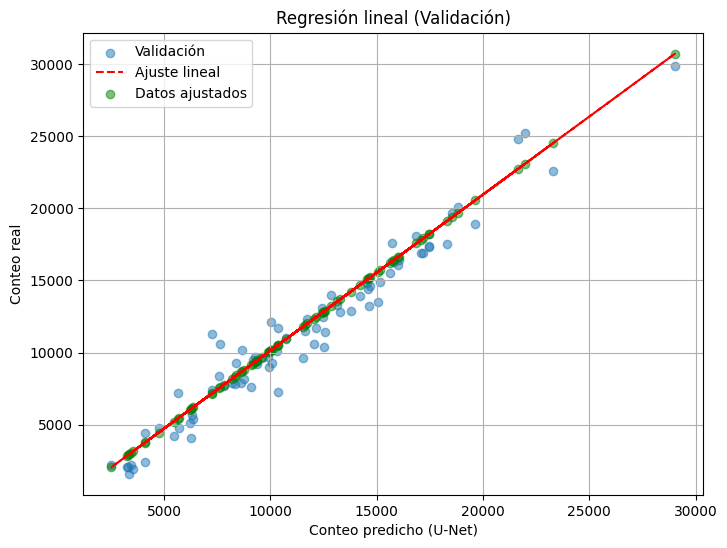

In [120]:
# Gráfico para el conjunto de validación
plt.figure(figsize=(8, 6))
plt.scatter(val_pred_counts, val_true_counts, label="Validación", alpha=0.5)
plt.plot(val_pred_counts, corrected_val_counts, color="red", linestyle='--', label="Ajuste lineal")
plt.scatter(X_val, corrected_val_counts, color='green', label="Datos ajustados",alpha=0.5)
plt.xlabel("Conteo predicho (U-Net)")
plt.ylabel("Conteo real")
plt.title("Regresión lineal (Validación)")
plt.legend()
plt.grid(True)
plt.show()

In [121]:
# Ejemplo
# Tomar una imagen del conjunto de validación como ejemplo
test_img_sample = val_images_all[0]  # Primera imagen de validación
predicted_map = model.predict(tf.expand_dims(test_img_sample, axis=0)).squeeze()
pred_count = np.sum(predicted_map)

# Aplicar la corrección
corrected_count = reg.predict([[pred_count]])
print(f"Conteo original: {pred_count:.2f} | Conteo corregido: {corrected_count[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Conteo original: 7592.59 | Conteo corregido: 7541.34


# Grafico de Bland Altman

## Train

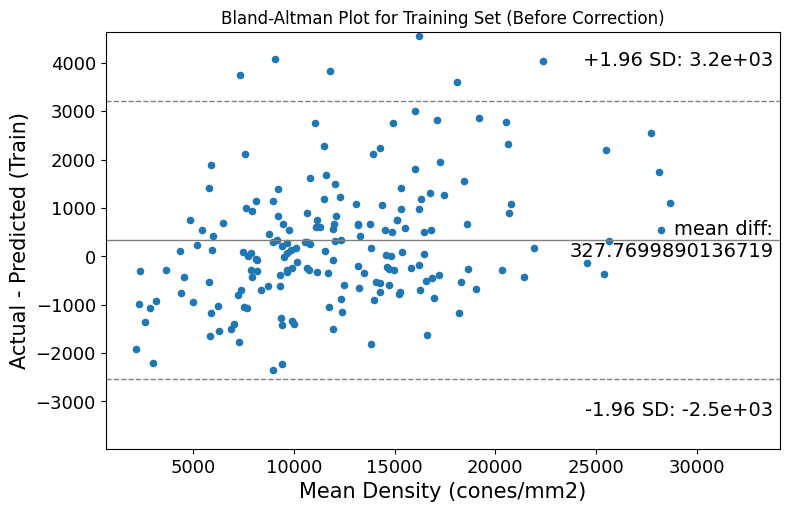

In [122]:
# Crear el gráfico de Bland-Altman
f, ax = plt.subplots(1, figsize=(8, 5))
sm.graphics.mean_diff_plot(train_true_counts, train_pred_counts, ax=ax)

# Etiquetas y título
plt.ylabel('Actual - Predicted (Train)')
plt.xlabel('Mean Density (cones/mm2)')
plt.title('Bland-Altman Plot for Training Set (Before Correction)')
plt.show()

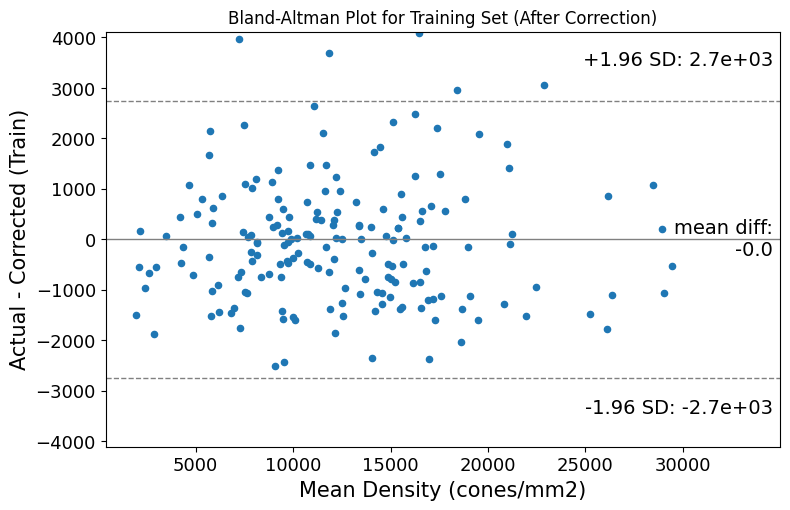

In [123]:
corrected_train_counts = reg.predict(X_train)

# Crear el gráfico de Bland-Altman
f, ax = plt.subplots(1, figsize=(8, 5))
sm.graphics.mean_diff_plot(train_true_counts, corrected_train_counts, ax=ax)

# Etiquetas y título
plt.ylabel('Actual - Corrected (Train)')
plt.xlabel('Mean Density (cones/mm2)')
plt.title('Bland-Altman Plot for Training Set (After Correction)')
plt.show()

## Validation

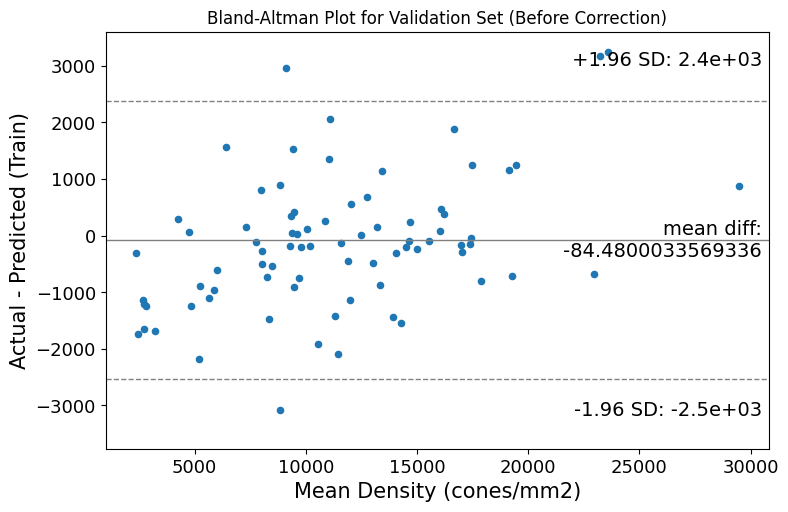

In [124]:
# Crear el gráfico de Bland-Altman
f, ax = plt.subplots(1, figsize=(8, 5))
sm.graphics.mean_diff_plot(val_true_counts, val_pred_counts, ax=ax)

# Etiquetas y título
plt.ylabel('Actual - Predicted (Train)')
plt.xlabel('Mean Density (cones/mm2)')
plt.title('Bland-Altman Plot for Validation Set (Before Correction)')
plt.show()

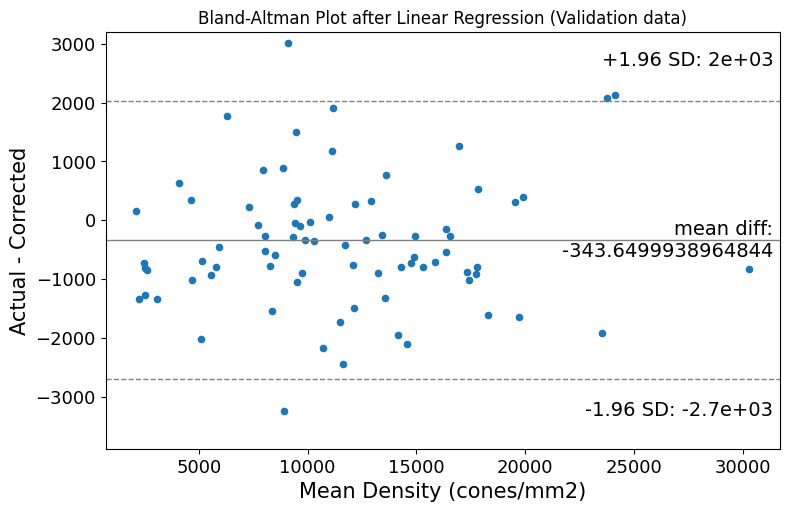

In [125]:
# Gráfico de mean-diff (Bland-Altman) después del ajuste lineal
f, ax = plt.subplots(1, figsize=(8, 5))
sm.graphics.mean_diff_plot(val_true_counts, corrected_val_counts, ax=ax)

plt.ylabel('Actual - Corrected')
plt.xlabel('Mean Density (cones/mm2)')
plt.title('Bland-Altman Plot after Linear Regression (Validation data)')
plt.show()

In [126]:
from sklearn.metrics import r2_score

y_true, y_pred = [], []

# Recorremos todo el validation set sin alterar el grafo
for batch_x, batch_y in val_dataset:
    preds = model(batch_x, training=False)
    y_true.append(batch_y.numpy().ravel())
    y_pred.append(preds.numpy().ravel())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Métricas
mae  = np.mean(np.abs(y_true - y_pred))
mse  = np.mean((y_true - y_pred)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2   = r2_score(y_true, y_pred)
corr = np.corrcoef(y_true, y_pred)[0,1]

print(f"MAE : {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f} %")
print(f"R²  : {r2:.3f}")
print(f"ρ   : {corr:.3f}")

MAE : 0.274
MSE: 1.210
RMSE: 1.100
MAPE: nan %
R²  : 0.101
ρ   : 0.318


<ipython-input-126-536331858>:18: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-126-536331858>:18: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [127]:
# EVALUACIÓN PRINCIPAL: Por conteos totales (RECOMENDADO)
from sklearn.metrics import r2_score

def evaluate_by_counts(model, dataset, apply_regression=False, reg_model=None):
    """
    Evalúa el modelo basándose en conteos totales por imagen
    """
    pred_counts, true_counts = [], []

    for batch_imgs, batch_dens in dataset:
        # Predicciones del modelo
        preds = model.predict(batch_imgs, verbose=0)

        # Calcular conteos (suma de cada mapa)
        batch_pred_counts = np.sum(preds, axis=(1,2,3))
        batch_true_counts = np.sum(batch_dens.numpy(), axis=(1,2,3))

        pred_counts.extend(batch_pred_counts)
        true_counts.extend(batch_true_counts)

    pred_counts = np.array(pred_counts)
    true_counts = np.array(true_counts)

    # Aplicar regresión lineal si se especifica
    if apply_regression and reg_model is not None:
        pred_counts = reg_model.predict(pred_counts.reshape(-1, 1)).flatten()

    # Calcular métricas
    mae = np.mean(np.abs(true_counts - pred_counts))
    mse = np.mean((true_counts - pred_counts)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_counts - pred_counts) / true_counts)) * 100
    r2 = r2_score(true_counts, pred_counts)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'pred_counts': pred_counts,
        'true_counts': true_counts
    }

# Evaluar ANTES de la regresión lineal
print("="*60)
print("EVALUACIÓN POR CONTEOS - ANTES DE REGRESIÓN LINEAL")
print("="*60)

results_before = evaluate_by_counts(model, val_dataset)
print(f"MAE  : {results_before['mae']:.3f} conos")
print(f"MSE  : {results_before['mse']:.3f}")
print(f"RMSE : {results_before['rmse']:.3f} conos")
print(f"MAPE : {results_before['mape']:.2f}%")
print(f"R²   : {results_before['r2']:.3f}")

# Evaluar DESPUÉS de la regresión lineal
print("\n" + "="*60)
print("EVALUACIÓN POR CONTEOS - DESPUÉS DE REGRESIÓN LINEAL")
print("="*60)

results_after = evaluate_by_counts(model, val_dataset, apply_regression=True, reg_model=reg)
print(f"MAE  : {results_after['mae']:.3f} conos")
print(f"MSE  : {results_after['mse']:.3f}")
print(f"RMSE : {results_after['rmse']:.3f} conos")
print(f"MAPE : {results_after['mape']:.2f}%")
print(f"R²   : {results_after['r2']:.3f}")

# Mostrar mejora
print("\n" + "="*60)
print("MEJORA CON REGRESIÓN LINEAL")
print("="*60)
mae_improvement = (results_before['mae'] - results_after['mae']) / results_before['mae'] * 100
mse_improvement = (results_before['mse'] - results_after['mse']) / results_before['mse'] * 100
rmse_improvement = (results_before['rmse'] - results_after['rmse']) / results_before['rmse'] * 100
mape_improvement = (results_before['mape'] - results_after['mape']) / results_before['mape'] * 100
r2_improvement = (results_after['r2'] - results_before['r2']) / abs(results_before['r2']) * 100

print(f"MAE  : {mae_improvement:+.2f}%")
print(f"MSE  : {mse_improvement:+.2f}%")
print(f"RMSE : {rmse_improvement:+.2f}%")
print(f"MAPE : {mape_improvement:+.2f}%")
print(f"R²   : {r2_improvement:+.2f}%")

EVALUACIÓN POR CONTEOS - ANTES DE REGRESIÓN LINEAL
MAE  : 921.624 conos
MSE  : 1575495.625
RMSE : 1255.188 conos
MAPE : 13.64%
R²   : 0.951

EVALUACIÓN POR CONTEOS - DESPUÉS DE REGRESIÓN LINEAL
MAE  : 977.046 conos
MSE  : 1571433.375
RMSE : 1253.568 conos
MAPE : 12.80%
R²   : 0.952

MEJORA CON REGRESIÓN LINEAL
MAE  : -6.01%
MSE  : +0.26%
RMSE : +0.13%
MAPE : +6.18%
R²   : +0.01%
